In [8]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy
from scipy.linalg import cholesky, cho_solve, solve_triangular
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import GPy as gpy
import GPy
import scipy.integrate as integrate


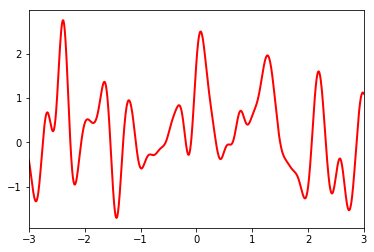

In [92]:
def sample_function(x_range, N=100, seed=4):
#     np.random.seed(seed)
    dx = x_range.shape[1]
    k = gpy.kern.src.rbf.RBF(input_dim=dx,lengthscale=0.1)
    x = np.random.uniform(x_range[0], x_range[1], (N, dx))
    cov = k.K(x, x)
    mu = np.zeros(x.shape[0])
    y = np.random.multivariate_normal(np.squeeze(mu), cov)[:, None]
    #import pdb; pdb.set_trace()
    m = gpy.models.GPRegression(x, y, k)#, mean_function=mean)
    m.likelihood.variance = 0.1

    def f(x): return m.predict(x)[0]
    return f
x_range = np.array([[-3.0], [3.0]])
f = sample_function(x_range)

def plot_f(f):
    xx = np.linspace(-3.0, 3.0, 1000).reshape(1000, 1)
    yy = f(xx)
    plt.plot(xx, yy, 'r', lw=2)
    plt.xlim(-3.0, 3.0)
    plt.show()
plot_f(f)

def plot(m):
    xx = np.linspace(-5.0, 5.0, 300).reshape(300, 1)
    mean, std = m.predict(xx)
    print mean, std
    mean = mean[:,0]
    plt.plot(xx, mean, 'r', lw=2)
    plt.fill_between(xx[:, 0],
                     mean - std**2,
                     mean + std**2,
                     color='r', alpha=0.2)
    plt.xlim(-5.0, 5.0)

[[-1.]
 [ 0.]
 [ 1.]]
[[-0.57666638]
 [ 1.7920221 ]
 [ 0.59987477]]


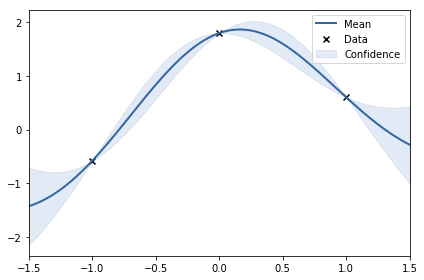

In [97]:
# k = GPy.kern.src.rbf.RBF(input_dim=1,lengthscale=0.1)
kernel = RBF(1.0, (1e-2, 1e2))
x = np.array([[-1.0],[0.0],[1.0]])
y = f(x)
gp = GPy.models.GPRegression(x, y, GPy.kern.src.rbf.RBF(input_dim=1),noise_var=0.0)
gp.likelihood.variance=0.0
gp.plot()
print x
print y

In [98]:
u,v = gp.predict(np.array([[0.3]]))
print u, v

def get_mean_func(gp):
    def f(x):
        Kxpx = gp.kern.K(np.array([[x]]),gp.X)
        return np.dot(Kxpx,gp.posterior.woodbury_vector)
    return f

def get_cov_func(gp):
    def f(x,y):
        Kxy = gp.kern.K(np.array([[x]]),np.array([[y]]))
        K1 = gp.kern.K(np.array([[x]]),gp.X)
        K2 = gp.kern.K(gp.X,np.array([[y]]))
        return Kxy - K1.dot(gp.posterior.woodbury_inv.dot(K2))
    return lambda x,y: f(x,y)

cov1 = lambda x,y: gp.kern.K(np.array([[x]]),np.array([[y]]))
cov2 = (lambda x,y: gp.kern.K(np.array([[x]]),gp.X).dot(gp.posterior.woodbury_inv.dot(gp.kern.K(gp.X,np.array([[y]])))))
# x = 0.3
# print gp.kernel_(np.array([[x]]),np.array([[0.0]]))

# def test_cov(gp):
#     def f(x):
#         print x
#         gp.kernel_(np.array([[x]]),np.array([[0.0]]))*gp.kernel_(gp.X_train_,gp.X_train_)*gp.kernel_(np.array([[0.0]]),np.array([[y]]))*normal(x)*normal(y)
#     return f
print get_mean_func(gp)(0.3)
print get_cov_func(gp)(0.3,0.3)
print cov1(0.3,0.3) - cov2(0.3,0.3)
gp.predict(np.array([[0.3]]))[0][0][0]

[[1.81193546]] [[0.01049321]]
[[1.81193546]]
[[0.01049321]]
[[0.01049321]]


1.8119354581171483

In [73]:
def normal(s):
    return scipy.stats.norm(0.0, np.sqrt(5.0)).pdf(s)

print "Mean Numerical Integration"
print integrate.quad(lambda x: gp.predict(np.array([[x]]))[0][0][0]*normal(x),np.NINF,np.inf)
# print integrate.quad(lambda x: gp.kernel_(np.array([[x]]),np.array([[0.0]]))*normal(x),np.NINF,np.inf)
# print "Var Numerical Integration"
# print integrate.quad(lambda x: gp.predict(x,return_std=True)[1][0]*normal(x),np.NINF,np.inf)
# print "other"
# print integrate.quad(lambda x: gp.kernel_(np.array([[x]]),np.array([[0.0]]))*normal(x),np.NINF,np.inf)
c1 = integrate.dblquad(lambda x,y: cov1(x,y)*normal(x)*normal(y),-5.0,5.0, lambda x: -5.0, lambda x: 5.0)
c2 = integrate.dblquad(lambda x,y: cov2(x,y)*normal(x)*normal(y),-5.0,5.0, lambda x: -5.0, lambda x: 5.0)
print c1,c2
print c1[0] - c2[0]
# print integrate.dblquad(lambda x,y: get_cov_func(gp)(x,y)*normal(x)*normal(y),-5.0,5.0, lambda x: -5.0, lambda x: 5.0)

# Mean Numerical Integration
# (0.09950371901104851, 8.07137139656537e-09)
# Var Numerical Integration
# (0.9499497153837378, 1.0189813132515364e-08)
# other
# (0.9645737664686658, 1.4874928277555785e-08)


Mean Numerical Integration
(0.2662380463601367, 2.3846680292591033e-09)
(0.3002628945129215, 2.286507609985944e-09) (0.192581919977802, 5.28540211597317e-10)
0.107680974535


In [74]:
b = np.array([0.0])
B = np.array([[5.0]])
def bintegrate(gp,b,B):
    n,dim = gp.X.shape
    length_scale = gp.kern.lengthscale[0]
    A = length_scale** 2 * np.diag(np.ones(dim))
    I = np.identity(dim)    
    X = gp.X
    z = np.zeros((n, 1))
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    for i in range(n):
        x = X[i, :]
        expon = np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        z[i, :] = determ * expon
    mean = np.dot(z.T,gp.posterior.woodbury_vector)
    
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
#     print var_determ
#     print np.dot(z.T, cho_solve((gp.L_, True), z))
    var = var_determ - np.dot(z.T, gp.posterior.woodbury_inv.dot(z))
    return mean[0][0], var[0][0]
bintegrate(gp,b,B)

(0.2662380463601368, 0.10892903347056646)

In [69]:
gp

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,0.0,+ve,


In [80]:
a = gpy.mappings.Linear(dx, 1)

In [327]:
gp.kernel_(gp.X_train_,gp.X_train_)

array([[1.]])

In [23]:
gp.kern.K

<bound method RBF.K of <GPy.kern.src.rbf.RBF object at 0x10b4c5a50>>